In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

## Load data

In [2]:
inputFiles = '../data/2mdm_spin0.pcl'

dmData = pd.read_pickle(inputFiles)

dmData.sort_values(['$m_{s}$', '$m_{Z^{\prime}}$', '$\sin\\alpha$', '$g_{q}$', '$g_{\chi}$',
                    '$y_{\chi}$', '$m_{\chi}$'], inplace=True, ascending=[True,True,True,True,True,True,True])
BRdata = pd.read_pickle('../data/BRdata.pcl')

## Filter data

In [10]:
## Filter DM data

filter_spin0 = {
    '$m_{\chi}$': 65.0,
    '$y_{\chi}$': 1.5,
    '$\sin\\alpha$': 0.25
}

dfModel = dmData.loc[(dmData[list(filter_spin0)] == pd.Series(filter_spin0)).all(axis=1)]
        
dfModel = dfModel[dfModel['Data-takingperiod'] == 2017]
dfModel = dfModel.rename(columns={'$m_{s}$': '$m_{med}$'})

BRdata = BRdata[BRdata['Mediator']=='spin-0']

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in filter_spin0.items()])

In [11]:
## Filter Branching ratio
col = ['$m_{med}$', '$\\sin\\alpha$', '$y_{\chi}$']

keys = list(dfModel[col].columns.values)
i1 = dfModel.set_index(keys).index
i2 = BRdata.set_index(keys).index
brS = BRdata[i2.isin(i1)]

### Auxiliar functions for plotting

In [12]:
def getBins(dfModel,rightBin = 1400.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return bins,binCenter,binLeft

def getMETbins(dfSingle,bins):

    data = {c : dfSingle[c].iloc[0] for c in bins}

    return data

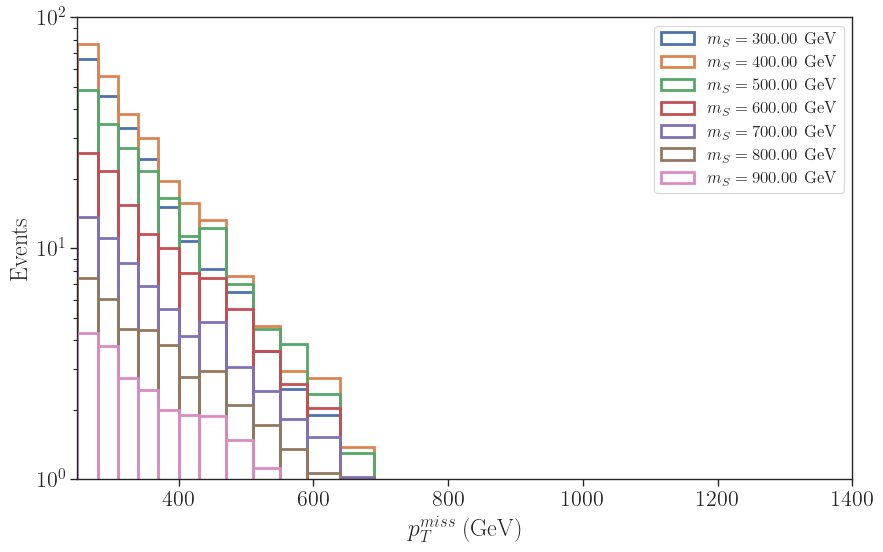

In [20]:
bins, binCenter, binLeft = getBins(dfModel)

fig = plt.figure(figsize=(10,6))

data = {}
weights = {}
for mass in dfModel['$m_{med}$']:
    dfSingle = dfModel[dfModel['$m_{med}$'] == mass]
    d = getMETbins(dfSingle, bins)
    data[mass] = d
    weights[mass] = np.array([data[mass][c] for c in bins])/np.array(brS[brS['$m_{med}$']==mass]['$BR(med>\\chi\\chi)$'])
    
colors = {label: sns.color_palette('deep')[i] for i, label in enumerate(data.keys())}

for mass in data:
    plt.hist(binCenter, bins=binLeft, label=r'$m_{S} = %1.2f$ GeV' %(mass), weights=weights[mass], 
             histtype='step', linewidth=2.0, color=colors[mass])
    
plt.yscale('log')
plt.ylim(1e0,1e2)
plt.xlabel(r'$p^{miss}_T$ (GeV)')
plt.ylabel(r'Events')
plt.xlim(250,1400)
plt.legend(loc='upper right', fontsize='x-small')

plt.show()